LookAt tests
=============

Import stuff
------------


In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
%matplotlib inline

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

def plotTogether(predictions, labels):
    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    t = np.arange(len(predictions)) * 0.02
    a = np.argmax(predictions, axis=1) * 0.99 + 0.02
    b = np.argmax(labels, axis=1) * 0.99 + 0.01

    plt.plot(t,a,'g') # plotting t,a separately 
    plt.plot(t,b,'b') # plotting t,b separately 
    plt.show()

def smoothPrediction(predictions):
    smoothWindow = 100
    smoothPred = np.zeros(predictions.shape)
    for i in range(smoothWindow//2):
        smoothPred[i] = predictions[i]
        smoothPred[-i] = predictions[-i]
    for i in range(len(predictions)-smoothWindow):
        mean = np.zeros(predictions.shape[1])
        for j in range(0,smoothWindow):
            mean += predictions[i+j]
        mean /= smoothWindow
        smoothPred[i+smoothWindow//2] = mean
    return smoothPred
        

First reload the data we generated in `00020_lookAtdataset.ipynb`.

In [2]:
timeWindow = 100
# train_file = './data/00020_lookAtdataset_train_w'+str(timeWindow)+'.pickle'
# valid_file = './data/00020_lookAtdataset_valid_w'+str(timeWindow)+'.pickle'
# test_file = './data/00020_lookAtdataset_test_w'+str(timeWindow)+'.pickle'

data_file = './data/00020_lookAtdataset__w'+str(timeWindow)+'.pickle'
testall_file = './data/00020_lookAtdataset_testall_w'+str(timeWindow)+'.pickle'

# with open(train_file, 'rb') as f:
#   dataset, labelset = pickle.load(f)
#   train_dataset = dataset[:, :]
#   train_labels = labelset[:, :]
#   del dataset,labelset  # hint to help gc free up memory
#   print('Training set', train_dataset.shape, train_labels.shape)

# with open(valid_file, 'rb') as f:
#   dataset, labelset = pickle.load(f)
#   valid_dataset = dataset[:, :]
#   valid_labels = labelset[:, :]
#   del dataset,labelset  # hint to help gc free up memory
#   print('Validation set', valid_dataset.shape, valid_labels.shape)

# with open(test_file, 'rb') as f:
#   dataset, labelset = pickle.load(f)
#   test_dataset = dataset[:, :]
#   test_labels = labelset[:, :]
#   del dataset,labelset  # hint to help gc free up memory
#   print('Test set', test_dataset.shape, test_labels.shape)

with open(data_file, 'rb') as f:
    dataset, labelset = pickle.load(f)
    dataLen = len(dataset)
    train_dataset = dataset[:int(dataLen*0.6), :]
    #add noise to train_dataset
    train_dataset += np.random.normal(0,0.1,train_dataset.shape[0]*train_dataset.shape[1]).reshape(train_dataset.shape)
    train_labels = labelset[:int(dataLen*0.6), :]
    valid_dataset = dataset[int(dataLen*0.6):int(dataLen*0.8), :]
    valid_labels = labelset[int(dataLen*0.6):int(dataLen*0.8), :]
    test_dataset = dataset[int(dataLen*0.8):, :]
    test_labels = labelset[int(dataLen*0.8):, :]
    del dataset,labelset  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

with open(testall_file, 'rb') as f:
  dataset, labelset = pickle.load(f)
  testall_dataset = dataset[:, :]
  testall_labels = labelset[:, :]
  del dataset,labelset  # hint to help gc free up memory
  print('Test ALL set', testall_dataset.shape, testall_labels.shape)

Training set (33244, 900) (33244, 6)
Validation set (11082, 900) (11082, 6)
Test set (11082, 900) (11082, 6)


ValueError: too many values to unpack (expected 2)

Stochastic gradient descent training

We create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

Off the shelf classifier (sklearn)

In [3]:
from sklearn import linear_model

X = train_dataset
Y = np.argmax(train_labels, axis=1)
X_test = test_dataset
Y_test = np.argmax(test_labels, axis=1)
logreg = linear_model.LogisticRegression(C=1e5)
# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(X, Y)
print('Score:',logreg.score(X_test, Y_test))

Score: 0.926006136077


In [4]:
from sklearn import svm
X = train_dataset
Y = np.argmax(train_labels, axis=1)
X_test = test_dataset
Y_test = np.argmax(test_labels, axis=1)

In [5]:
lin_clf = svm.LinearSVC()
lin_clf.fit(X, Y)
print('LinearSVC score:',lin_clf.score(X_test, Y_test))

LinearSVC score: 0.921133369428


In [6]:
clf = svm.SVC()
clf.fit(X, Y)
print('SVC score:',clf.score(X_test, Y_test))

SVC score: 0.881790290561


---
Tensorflow logistic regression
-------
---

In [7]:
batch_size = 256
dataSize = train_dataset.shape[1]
labelSize = train_labels.shape[1]

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, dataSize))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, labelSize))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_testall_dataset = tf.constant(testall_dataset)
  
  # Variables.
  weights = tf.Variable(tf.truncated_normal([dataSize, labelSize], stddev=tf.sqrt(2./(dataSize))))
  biases = tf.Variable(tf.zeros([labelSize]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + 0.00001*tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
  testall_prediction = tf.nn.softmax(tf.matmul(tf_testall_dataset, weights) + biases)

Initialized
Minibatch loss at step 0: 1.864317
Minibatch accuracy: 13.7%
Validation accuracy: 16.5%
Minibatch loss at step 500: 1.450217
Minibatch accuracy: 71.9%
Validation accuracy: 81.9%
Minibatch loss at step 1000: 1.211975
Minibatch accuracy: 77.7%
Validation accuracy: 83.1%
Minibatch loss at step 1500: 1.068785
Minibatch accuracy: 80.9%
Validation accuracy: 83.7%
Minibatch loss at step 2000: 0.947545
Minibatch accuracy: 82.8%
Validation accuracy: 84.8%
Minibatch loss at step 2500: 0.943172
Minibatch accuracy: 75.0%
Validation accuracy: 85.3%
Minibatch loss at step 3000: 0.840131
Minibatch accuracy: 82.4%
Validation accuracy: 85.7%
Minibatch loss at step 3500: 0.734353
Minibatch accuracy: 83.6%
Validation accuracy: 86.4%
Minibatch loss at step 4000: 0.686717
Minibatch accuracy: 89.1%
Validation accuracy: 86.3%
Minibatch loss at step 4500: 0.712995
Minibatch accuracy: 81.6%
Validation accuracy: 87.1%
Minibatch loss at step 5000: 0.689017
Minibatch accuracy: 84.4%
Validation accurac

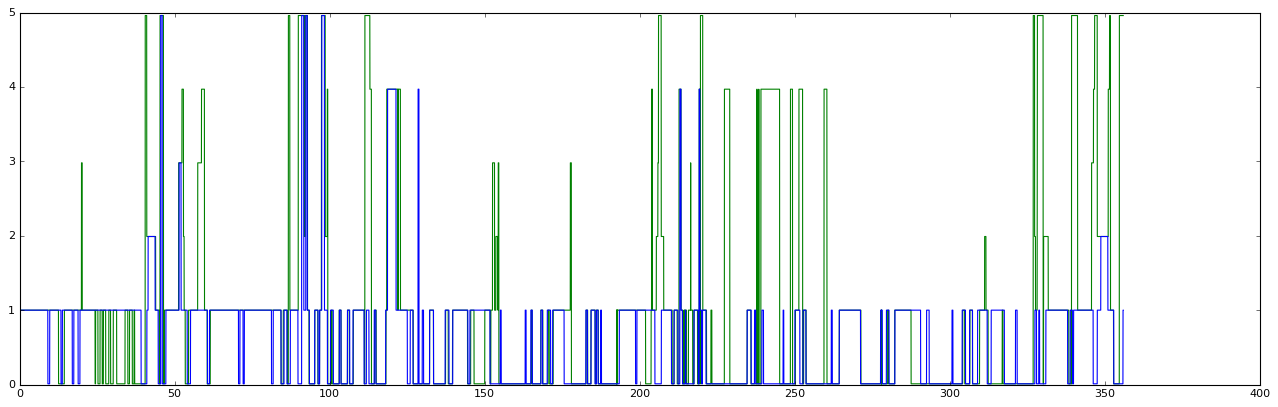

In [8]:
num_steps = 30001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  pred = testall_prediction.eval()
  print("Test accuracy: %.1f%%" % accuracy(pred, testall_labels))
  plotTogether(pred, testall_labels)

---
Tensorflow MLP
-------
---

In [3]:
prediction_file = './data/00020_lookAtdataset_testall_w'+str(timeWindow)+'.pickle'

with open(prediction_file, 'rb') as f:
  dataset = pickle.load(f)
  testall_dataset = dataset
  del dataset  # hint to help gc free up memory

In [4]:
dataSize = train_dataset.shape[1]
labelSize = train_labels.shape[1]
num_steps = 20001
batch_size = 256

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, dataSize))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, labelSize))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_testall_dataset = tf.constant(testall_dataset)
  
  hidden_size = 512

  # Variables.
  weights1 = tf.Variable(tf.truncated_normal([dataSize, hidden_size], stddev=tf.sqrt(2./(dataSize))))
  biases1 = tf.Variable(tf.zeros([hidden_size]))
  weights2 = tf.Variable(tf.truncated_normal([hidden_size, labelSize], stddev=tf.sqrt(2./(hidden_size))))
  biases2 = tf.Variable(tf.zeros([labelSize]))
  
  # Training computation.
  logits1 = tf.matmul(tf_train_dataset, weights1) + biases1
  relu1 = tf.nn.relu(logits1)
  relu1drop = tf.nn.dropout(relu1, keep_prob=0.5)
  logits2 = tf.matmul(relu1drop, weights2) + biases2
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits2)) + 0.001*tf.nn.l2_loss(weights1)
  
  # Optimizer.
#   global_step = tf.Variable(0)
#   learning_rate = tf.train.exponential_decay(0.03, global_step, 3000, 0.5, staircase=True)
#   optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#   gradients, v = zip(*optimizer.compute_gradients(loss))
#   #gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
#   optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=global_step)
  #optimizer = tf.train.GradientDescentOptimizer(0.03).minimize(loss)
  optimizer = tf.train.MomentumOptimizer(0.001, 0.99).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits2)
  valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1),weights2)+biases2)
  test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1),weights2)+biases2)
  testall_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_testall_dataset, weights1) + biases1),weights2)+biases2)

  saver = tf.train.Saver()


Initialized
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 16.8%
Test accuracy: 16.7%
####################################
Minibatch loss at step 0: 2.299126
Minibatch accuracy: 12.9%
Validation accuracy: 16.8%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 16.9%
Test accuracy: 16.8%
####################################
Minibatch loss at step 11: 2.261226
Minibatch accuracy: 12.9%
Validation accuracy: 16.9%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 17.1%
Test accuracy: 17.0%
####################################
Minibatch loss at step 12: 2.254035
Minibatch accuracy: 18.0%
Validation accuracy: 17.1%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 17.8%
Test accuracy: 17.8%
####################################
Minibatch loss at step 13: 2.218477
Minibatch accuracy: 17.2%
Validation accuracy: 17.8%
Model saved i

Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 80.9%
Test accuracy: 81.2%
####################################
Minibatch loss at step 130: 1.706093
Minibatch accuracy: 62.5%
Validation accuracy: 80.9%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 81.0%
Test accuracy: 81.1%
####################################
Minibatch loss at step 160: 1.546324
Minibatch accuracy: 66.4%
Validation accuracy: 81.0%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 81.7%
Test accuracy: 81.7%
####################################
Minibatch loss at step 161: 1.606110
Minibatch accuracy: 62.5%
Validation accuracy: 81.7%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 82.1%
Test accuracy: 82.1%
####################################
Minibatch loss at step 162: 1.620450
Minibatch accuracy: 62.5%
Validation accuracy: 82.1%
Model saved in file:

Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 87.5%
Test accuracy: 87.6%
####################################
Minibatch loss at step 409: 0.930190
Minibatch accuracy: 85.9%
Validation accuracy: 87.5%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 87.5%
Test accuracy: 87.7%
####################################
Minibatch loss at step 410: 0.925504
Minibatch accuracy: 83.6%
Validation accuracy: 87.5%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 87.6%
Test accuracy: 87.6%
####################################
Minibatch loss at step 412: 0.898732
Minibatch accuracy: 81.2%
Validation accuracy: 87.6%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 88.0%
Test accuracy: 87.9%
####################################
Minibatch loss at step 489: 0.866975
Minibatch accuracy: 84.8%
Validation accuracy: 88.0%
Minibatch loss at st

Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 90.1%
Test accuracy: 90.2%
####################################
Minibatch loss at step 804: 0.679165
Minibatch accuracy: 87.9%
Validation accuracy: 90.1%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 90.1%
Test accuracy: 90.2%
####################################
Minibatch loss at step 805: 0.762322
Minibatch accuracy: 84.4%
Validation accuracy: 90.1%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 90.1%
Test accuracy: 90.0%
####################################
Minibatch loss at step 854: 0.743929
Minibatch accuracy: 87.5%
Validation accuracy: 90.1%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 90.2%
Test accuracy: 90.2%
####################################
Minibatch loss at step 857: 0.729968
Minibatch accuracy: 87.5%
Validation accuracy: 90.2%
Model saved in file:

Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 91.8%
Test accuracy: 92.1%
####################################
Minibatch loss at step 1248: 0.668066
Minibatch accuracy: 89.8%
Validation accuracy: 91.8%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 91.9%
Test accuracy: 92.1%
####################################
Minibatch loss at step 1249: 0.682492
Minibatch accuracy: 87.9%
Validation accuracy: 91.9%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 91.9%
Test accuracy: 92.2%
####################################
Minibatch loss at step 1250: 0.658346
Minibatch accuracy: 90.2%
Validation accuracy: 91.9%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 92.0%
Test accuracy: 92.2%
####################################
Minibatch loss at step 1252: 0.738930
Minibatch accuracy: 85.2%
Validation accuracy: 92.0%
Model saved in f

Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 92.9%
Test accuracy: 93.4%
####################################
Minibatch loss at step 1916: 0.617218
Minibatch accuracy: 88.3%
Validation accuracy: 92.9%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 93.0%
Test accuracy: 93.4%
####################################
Minibatch loss at step 1917: 0.626536
Minibatch accuracy: 88.7%
Validation accuracy: 93.0%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 93.0%
Test accuracy: 93.4%
####################################
Minibatch loss at step 1918: 0.588122
Minibatch accuracy: 90.6%
Validation accuracy: 93.0%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 93.1%
Test accuracy: 93.5%
####################################
Minibatch loss at step 1919: 0.589037
Minibatch accuracy: 91.0%
Validation accuracy: 93.1%
Minibatch loss a

Minibatch loss at step 4000: 0.383228
Minibatch accuracy: 95.7%
Validation accuracy: 93.3%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 94.0%
Test accuracy: 94.5%
####################################
Minibatch loss at step 4093: 0.436882
Minibatch accuracy: 90.6%
Validation accuracy: 94.0%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 94.0%
Test accuracy: 94.5%
####################################
Minibatch loss at step 4095: 0.423435
Minibatch accuracy: 93.0%
Validation accuracy: 94.0%
Minibatch loss at step 4500: 0.470778
Minibatch accuracy: 89.5%
Validation accuracy: 93.7%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 94.1%
Test accuracy: 94.4%
####################################
Minibatch loss at step 4551: 0.381157
Minibatch accuracy: 93.0%
Validation accuracy: 94.1%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid

Minibatch loss at step 7500: 0.309639
Minibatch accuracy: 93.8%
Validation accuracy: 94.4%
Minibatch loss at step 8000: 0.326905
Minibatch accuracy: 92.6%
Validation accuracy: 94.2%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 94.9%
Test accuracy: 95.4%
####################################
Minibatch loss at step 8422: 0.292871
Minibatch accuracy: 91.8%
Validation accuracy: 94.9%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 95.0%
Test accuracy: 95.4%
####################################
Minibatch loss at step 8423: 0.298227
Minibatch accuracy: 93.8%
Validation accuracy: 95.0%
Minibatch loss at step 8500: 0.330840
Minibatch accuracy: 91.0%
Validation accuracy: 94.4%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 95.0%
Test accuracy: 95.5%
####################################
Minibatch loss at step 8932: 0.261751
Minibatch accuracy: 96.1%
Validation accur

Minibatch loss at step 19000: 0.186382
Minibatch accuracy: 96.1%
Validation accuracy: 94.9%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 95.8%
Test accuracy: 96.1%
####################################
Minibatch loss at step 19164: 0.206661
Minibatch accuracy: 94.9%
Validation accuracy: 95.8%
Model saved in file: ./bestModel.ckpt
########## Found new best ##########
Valid accuracy: 95.8%
Test accuracy: 96.2%
####################################
Minibatch loss at step 19165: 0.176009
Minibatch accuracy: 98.4%
Validation accuracy: 95.8%
Minibatch loss at step 19500: 0.186659
Minibatch accuracy: 94.5%
Validation accuracy: 95.2%
Minibatch loss at step 20000: 0.179487
Minibatch accuracy: 94.9%
Validation accuracy: 94.5%
Test ALL accuracy: 85.6%


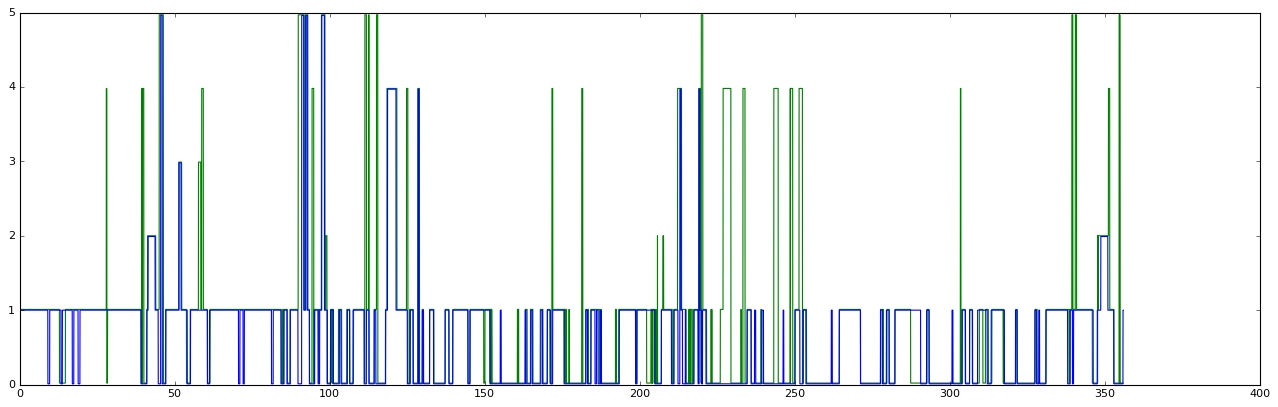

########## Best scores ##########
Valid accuracy: 95.8%
Test accuracy: 96.2%
####################################


In [7]:
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
    
  bestValidScore = 0
  bestValidTestScore = 0
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    validScore = accuracy(valid_prediction.eval(), valid_labels)
    foundNewBest = False
    if validScore > bestValidScore:
        bestValidScore = validScore
        foundNewBest = True
    if (step % 500 == 0) or foundNewBest==True:
      #print('Learning rate:', learning_rate.eval())
      if foundNewBest:
        #############
        save_path = saver.save(session, "./bestModel.ckpt")
        print("Model saved in file: %s" % save_path)
        #############
        print('########## Found new best ##########')
        print("Valid accuracy: %.1f%%" % (bestValidScore))
        pred = test_prediction.eval()
        bestValidTestScore = accuracy(pred, test_labels)
        print("Test accuracy: %.1f%%" % bestValidTestScore)
        print('####################################')
        
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
  pred = testall_prediction.eval()
  print("Test ALL accuracy: %.1f%%" % accuracy(pred, testall_labels))
  plotTogether(pred, testall_labels)
#   pred = smoothPrediction(pred)
#   print("Smooth accuracy: %.1f%%" % accuracy(pred, testall_labels))
#   plotTogether(pred, testall_labels)
  print('########## Best scores ##########')
  print("Valid accuracy: %.1f%%" % (bestValidScore))
  pred = test_prediction.eval()
  print("Test accuracy: %.1f%%" % bestValidTestScore)
  print('####################################')

---
Tensorflow MLP - Prediction
-------
---

In [6]:
from elanExport import exportELAN
    
with tf.Session(graph=graph) as session:
    # Restore variables from disk.
    saver.restore(session, "./bestModel.ckpt")
    print("Model restored.")

    pred = testall_prediction.eval()
    
#     print("Test ALL accuracy: %.1f%%" % accuracy(pred, testall_labels))
#     plotTogether(pred, testall_labels)
    
    lookAtLabelList = ['look_down', 'look_patient', 'look_top_left', 'look_top_right', 'look_down_left', 'look_down_right']
    videoFileName = '00020.mp4'
    videoPath = 'file:///media/mike/5EED132D43AA74B1/sombrero_data/data/lucie/2017/gros plan/emilie/'+videoFileName
    exportELAN(elanFile=videoFileName+'.eaf', predictions=pred, annotations=lookAtLabelList, startTime=20*timeWindow//2, videoPath=videoPath, videoFileName=videoFileName)

INFO:tensorflow:Restoring parameters from ./bestModel.ckpt
Model restored.


In [7]:
from elanExport import exportELAN
    
with tf.Session(graph=graph) as session:
    # Restore variables from disk.
    saver.restore(session, "./bestModel.ckpt")
    print("Model restored.")

    pred = testall_prediction.eval()
    
    lookAtLabelList = ['look_down', 'look_patient', 'look_top_left', 'look_top_right', 'look_down_left', 'look_down_right']
    videoFileName = '00021.mp4'
    videoPath = 'file:///media/mike/5EED132D43AA74B1/sombrero_data/data/lucie/2017/gros plan/emilie/'+videoFileName
    exportELAN(elanFile=videoFileName+'.eaf', predictions=pred, annotations=lookAtLabelList, startTime=20*timeWindow//2, videoPath=videoPath, videoFileName=videoFileName)

INFO:tensorflow:Restoring parameters from ./bestModel.ckpt
Model restored.
